(Temporary) upload file in Colab then specify path and filename

In [ ]:
!mkdir input
!mkdir output

url, filename = ("/content/input/bankst.jpg", "bankst.jpg") # IMAGE MUST BE JPG

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘output’: File exists


# Setup

In [ ]:
!pip install timm

In [ ]:
import cv2
import torch
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Move model to GPU if available

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

Load transforms to resize and normalize the image for large or small model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [ ]:
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Image as a numpy ndarray
input_batch = transform(img).to(device)
plt.imshow(img)
plt.axis('off')

(-0.5, 1241.5, 678.5, -0.5)

Predict depths and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show depth prediction

In [ ]:
plt.imshow(output, cmap='gray')
plt.axis('off')
output.shape

(679, 1242)

# Image segmentation
Set up image segmentation

In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from matplotlib import cm

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

Reshape and normalise depth map (currently redundant)

In [ ]:
output_reshape = np.dstack((output, output, output)) # Convert to image with 3 dimensions
output_reshape = (output_reshape-np.min(output_reshape))/(np.max(output_reshape)-np.min(output_reshape))

Predict image segments

In [ ]:
img_pil = Image.open(url)

inputs = processor(img_pil, return_tensors='pt')

with torch.no_grad():
  outputs = model(**inputs)

prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img_pil.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


Display image segments

In [ ]:
from collections import defaultdict
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)
draw_panoptic_segmentation(prediction['segmentation'], prediction['segments_info'])

<ipython-input-13-48b15c2a5c09>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


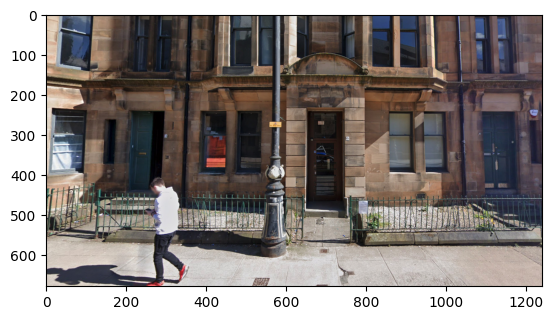

In [ ]:
plt.imshow(img)

Take each segment and create a mask

In [ ]:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb

def get_mask(segment_id):
  mask = (prediction['segmentation'].numpy() == segment_id) # move to cell below
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

Create a dictionary with value PIL image of mask and corresponding depth value pair

In [ ]:
from scipy import stats

In [ ]:
def mask_generator():
    for segment_info in prediction['segments_info']:
        mask_pil = get_mask(segment_info['id'])
        mask_pil = mask_pil.convert('RGB')
        mask_pil = mask_pil.convert('L')
        depth = np.median(output[np.array(mask_pil)]) # To solve - better average depth calculation
        yield mask_pil, depth

Populate using list with details

In [ ]:
mask_info_list = []
for i, (mask_pil, depth) in enumerate(mask_generator()):
  mask_info_list.append([mask_pil, depth])

In [ ]:
def display_images(images, size=(50, 10)):
  fig, axes = plt.subplots(1, len(images), figsize=size)

  # Iterate through the images and display them
  for i, plane in enumerate(images):
      axes[i].imshow(plane)
      axes[i].axis('off')

  plt.show()

Sort the list by depth ascending

In [ ]:
mask_info = sorted(mask_info_list, key=lambda x: x[1])
print("Average depths of segments in ascending order")
for mask in mask_info:
  print(mask[1])

Average depths of segments in ascending order
7.9246554
7.969194
7.9791064
7.984064


Display the masks

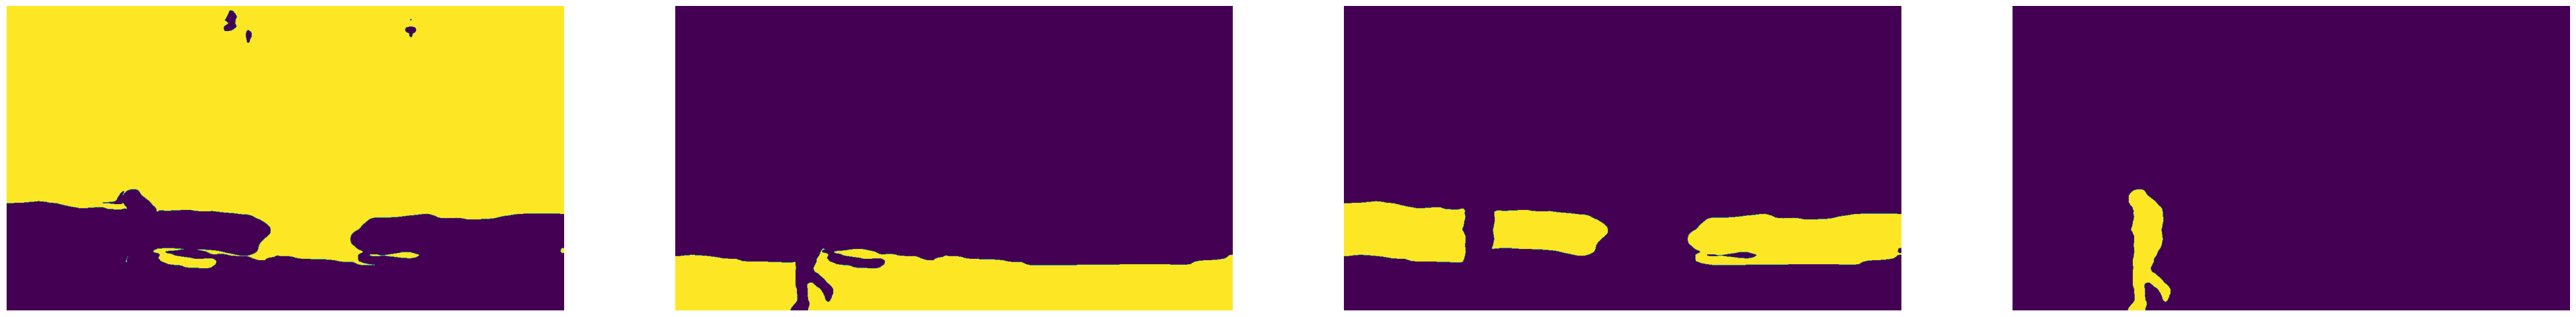

In [ ]:
display_images([mask[0] for mask in mask_info])

Create depth ranges to chop image into

In [ ]:
depth_ranges = [[mask_info[i][1], mask_info[i+1][1]] for i in range(len(mask_info)-1)]
print(depth_ranges)

[[7.9246554, 7.969194], [7.969194, 7.9791064], [7.9791064, 7.984064]]


Chop the image into different depth levels

In [ ]:
depth_planes = []
for (a,b) in depth_ranges:
  for mask in mask_info:
    if a <= mask[1] <= b:
      mask_reshape = np.stack((mask[0], mask[0], mask[0]), axis=-1)
      depth_planes.append(np.where(mask_reshape, img, mask_reshape))
print("There are " + str(len(depth_planes)) + " depth planes" )
depth_planes.reverse()

There are 6 depth planes


(Temporary solution) remove duplicate planes

In [ ]:
unique_planes = []

for plane in depth_planes:
  if not any(np.array_equal(plane, unique) for unique in unique_planes):
    unique_planes.append(plane)
print(str(len(unique_planes)) + " unique depth planes")

4 unique depth planes


Display the different depth planes

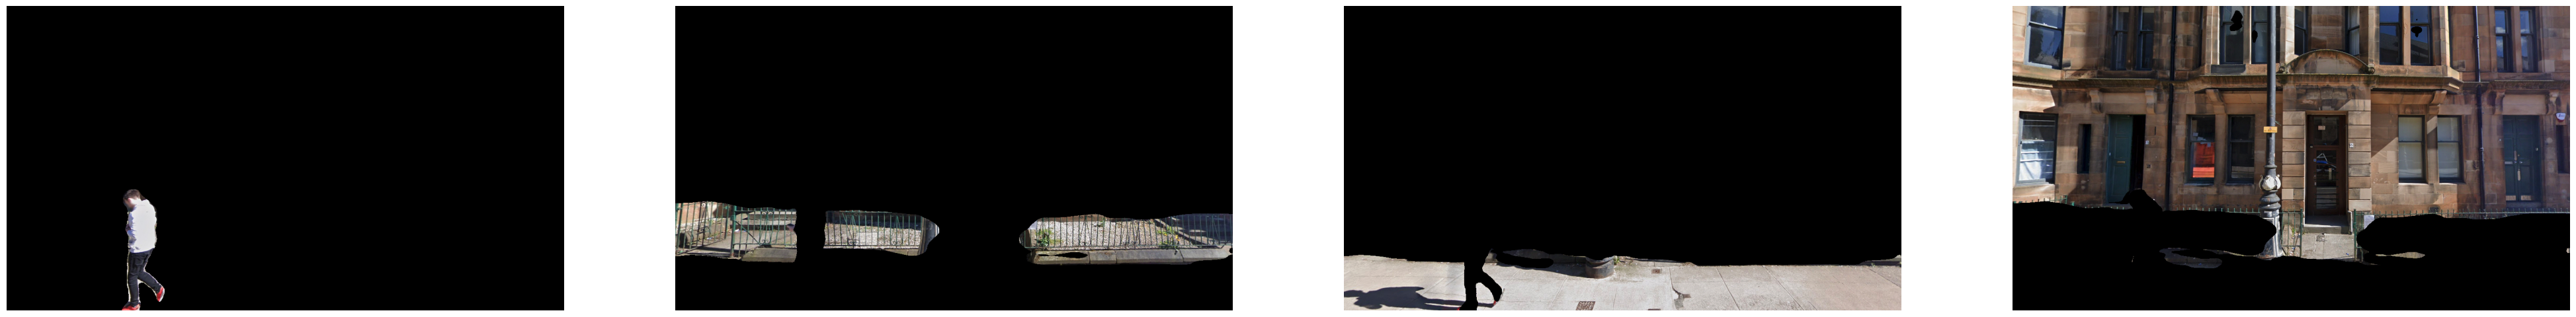

In [ ]:
display_images(unique_planes)

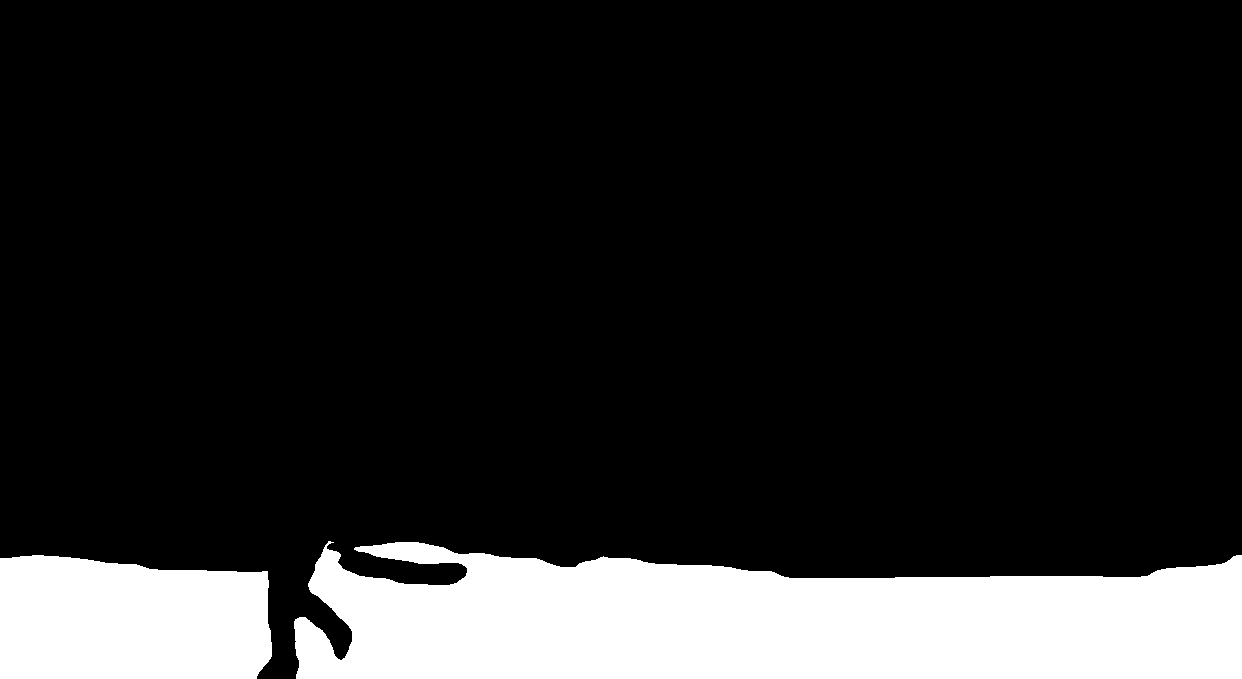

In [ ]:
mask_info[1][0]

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

In [ ]:
import inspect
from typing import List, Optional, Union

import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


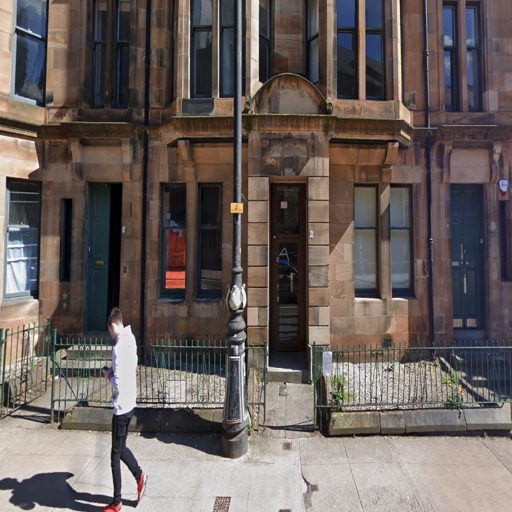

In [ ]:
inpaint_img = img_pil.resize((512, 512))
inpaint_img

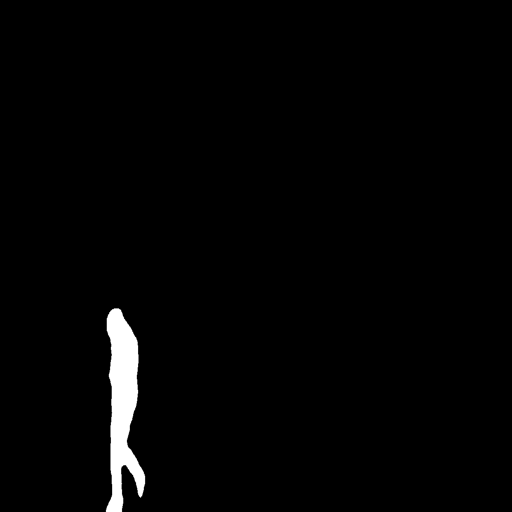

In [ ]:
mask_image = mask_info[3][0].resize((512, 512))
mask_image

In [ ]:
prompt = "Remove person"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=inpaint_img,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# insert initial image in the list so we can compare side by side
images.insert(0, inpaint_img)

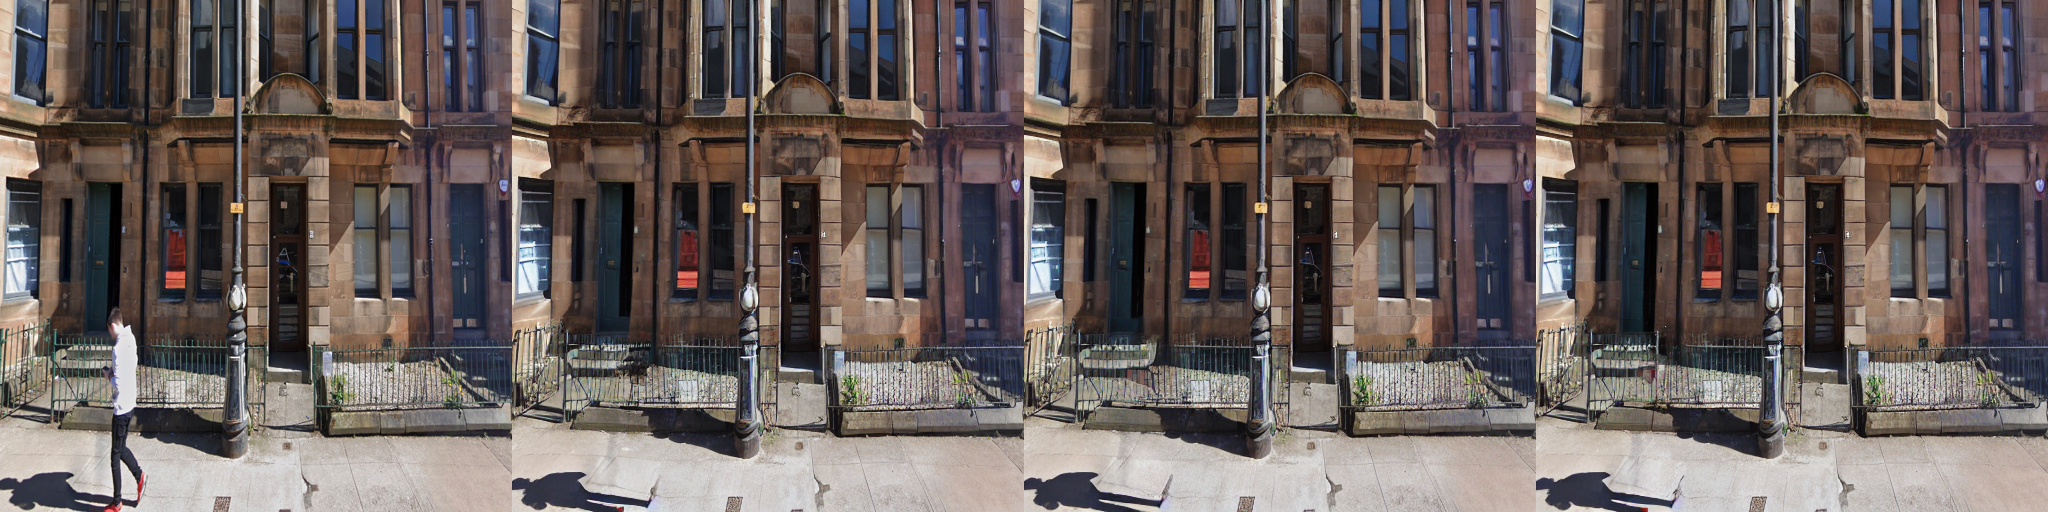

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(images, 1, num_samples + 1)

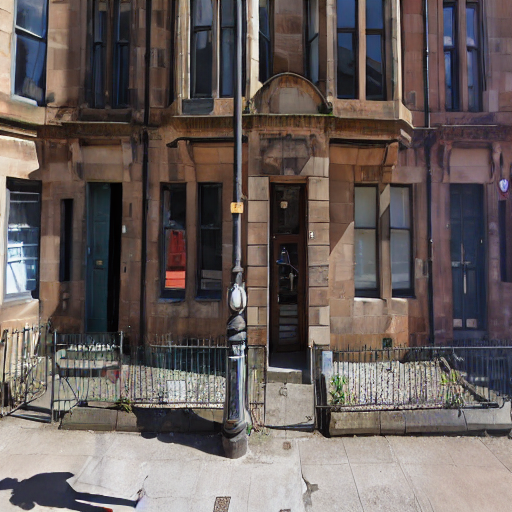

In [ ]:
images[3]

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

SyntaxError: ignored

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}